In [ ]:
#Imports to provide additional functionality to the program
import matplotlib.pyplot as plt
%matplotlib inline 


import sep 
import math 
import keras
from keras.utils import np_utils 
import numpy as np 
from astropy.io import fits
from astropy.visualization import ZScaleInterval 
from astropy import wcs 
from astropy.wcs import WCS 
from astropy.coordinates import SkyCoord 

import random 
import aplpy 
from astroquery.sdss import SDSS 

from sklearn.metrics import accuracy_score 

np.random.seed(123)  

2023-03-13 15:26:14.654219: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
#gauss takes three arguments "shape-dimensions of numpy array" "th-angle of rotation in radians 2D"
#sigma standard deviation of Gaussian in x and y direction
#unpacks the values in sigma variables 'sx' and 'sy'

def gauss(shape, th=0.0, sigma=(1.0, 1.0)):
    """Create a numpy array of given shape, 
    with a centered 2D un-normalized Gaussian
    with (sigma_x, sigma_y) covariance matrix,
    rotated th radians counter-clockwise."""
    sx, sy = sigma #unpacks the values in sigma variables 'sx' and 'sy'
    h, w = shape #unpacks the values into variables 'h' and 'w'
    cov = np.array([[sy, 0.], [0., sx]]) #2x2 numy array called covariance matrix 2D gaussian  
    rotm = np.array([[np.cos(th), np.sin(th)], [-np.sin(th), np.cos(th)]]) #rotation martix 2x2 numpy array
    cov_rot = rotm.T.dot(cov).dot(rotm) #applies to convariance matrixz by multiply by transpose of the rotation matrix
    covinv = np.linalg.inv(cov_rot) #computes the inverse of the rotated covariance matrix 
    xv = x, y = np.mgrid[:h,:w] #generates a 2D grid point x and y direction resulting griss is assigned xv and x and y 
    x0 = np.array([h / 2, w / 2]) #creates an array that represents the center of the grid. divides the dimension of the grid by 2
    chisq = np.zeros(shape) #created a 2D array of zeros that has same shape as the grid 
    #nested loops iterate over every point in the grid and compute the chi square value for each point.
    for i in range(h):
        for j in range(w):
            chisq[i, j] = ((xv[:,i,j] - x0).dot(covinv)).dot((xv[:,i,j] - x0))
    g = np.exp(-0.5 * chisq)
    # g = g / np.sum(g)
    return g

In [4]:
#defines a function that takes a single argument
def make_samples(n_samples):
    """Create n_samples of pairs of (new, reference) images
    in which `new` may or may not contain a transient with equal probability.
    The sources, when present, have random parameters of `gauss`."""
    thumb_size = (21, 21) #size of the image
    noise_sigma = 0.5 #standard deviation of the noise
    sky_mean = 0.0 #mean of the background sky 
    smp_x_list = []
    smp_y_list = []    
    for i in range(n_samples): #loop will run n_sampes 
        bkg = np.random.normal(sky_mean, noise_sigma, size=thumb_size) #generate background noise
        th = np.random.rand() * 2.0 * np.pi
        amp = 35.0 + np.random.rand() * 10.0 #generate random parameter for the source rotation "th" amplitude "amp" and standard deviation x and y 
        sx = 5 + np.random.rand() * 1.5 
        sy = 5 + np.random.rand() * 1.5
        src = (sky_mean + amp * noise_sigma) * gauss(thumb_size, th=th, sigma=(sx, sy)) #generate the source image
        img1 = src + bkg #adds the source and background images to get new image (img1)

        bkg = np.random.normal(sky_mean, noise_sigma, size=thumb_size) #generates a new background image
        has_transient = np.random.rand() > 0.5 #determine whether the new image will have a transient by checking random #
        if has_transient:
            src = np.zeros(thumb_size)
        else:
            th = np.random.rand() * 2.0 * np.pi
            amp = 5.0 + np.random.rand() * 15.0
            sx = 0.5 + np.random.rand() * 1.5
            sy = 0.5 + np.random.rand() * 1.5
            src = (sky_mean + amp * noise_sigma) * gauss(thumb_size, th=th, sigma=(sx, sy))
        img2 = src + bkg #generates a final reference image by adding the background and source image and store it as img2
        
        smp_x_list.append([img1, img2]) 
        smp_y_list.append(1 if has_transient else 0)
    return np.array(smp_x_list), np.array(smp_y_list)

In [5]:
#generate 10 pairs of the new and reference images with or without a transient 
data_sim, labels = make_samples(10) 

In [6]:
#return the shape numoy array containing four elements which means 4D numy array with 10 samples each
#containing 2 images of size 21 x 21 pixels 
data_sim.shape

(10, 2, 21, 21)

In [7]:
#selects the first image in the second sample
data_sim[1,0,:,:] 

array([[ 2.82460083e-01,  8.56400468e-01,  3.55069699e-01,
        -7.89141303e-02,  1.72071714e-01,  3.57944174e-02,
         1.95234609e-01,  4.13014183e-01,  3.55199014e-01,
        -5.12970934e-01,  1.03215010e-01,  3.74487712e-01,
        -1.16013966e-01,  1.09982152e-01, -1.32486904e-01,
         5.91158798e-01,  1.70317025e-01,  2.36131701e-01,
        -4.93283120e-02,  5.85236344e-01, -4.92088425e-01],
       [ 5.80113573e-01, -1.98735320e-01, -2.51794879e-03,
         9.10543293e-01, -1.79136960e-02, -7.55865293e-02,
        -5.31828666e-02,  5.36390645e-01, -2.26513880e-01,
         5.57480073e-01, -4.91273362e-01, -3.88901777e-01,
         7.44551097e-01,  2.60804533e-01, -2.35781833e-01,
         2.70229146e-01,  4.28283748e-03,  5.08954955e-01,
         8.62410649e-01,  3.78788544e-01, -4.68425635e-01],
       [ 3.90361929e-01, -2.39088618e-01, -6.55683225e-02,
         2.11612495e-01,  4.07045528e-01, -5.89764432e-03,
        -3.49605913e-01,  4.13905551e-01,  3.47978959e

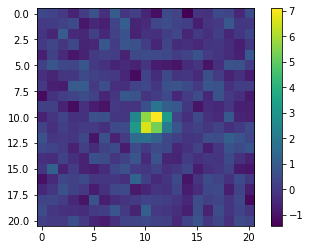

In [25]:
#creates a fugre object and display an image index (6,1) of the data_sim particular image to display
fig_1 = plt.imshow(data_sim[6,1,:,:])
plt.colorbar(fig_1)
    

In [9]:
labels

array([1, 0, 0, 0, 1, 1, 0, 1, 0, 0])

In [10]:
def show_field(field1,field2): #takes two arguments which are 2d numpy arrays representing grayscale images

    combined_data = np.array([field1,field2]) #combines and get the min and max arrays of the grayscale images
    #Get the min and max of all your data
    _min, _max = np.amin(combined_data), np.amax(combined_data) 

    fig = plt.figure()
    ax = fig.add_subplot(2, 1, 1)
    #Add the vmin and vmax arguments to set the color scale
    ax.imshow(field1, vmin = _min, vmax = _max,cmap='gray')
    ax.autoscale(False)
    ax2 = fig.add_subplot(2, 1, 2)
    #Add the vmin and vmax arguments to set the color scale
    ax2.imshow(field2, vmin = _min, vmax = _max,cmap='gray')
    ax2.autoscale(False)
    plt.show()

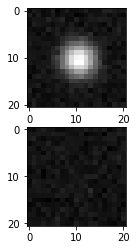

In [11]:
show_field(data_sim[0,0,:,:],data_sim[0,1,:,:])

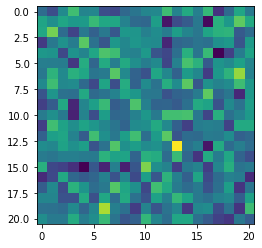

In [12]:
#reference image image second image
plt.imshow(data_sim[0,1,:,:])

In [15]:
#createdataset2 = np.zeros((10000,21,21,2)) #which means 10000 samples each image 21by21 pixels and 2 channels one of the new image and one for reference images an numpy shape filled with zeros which will be stores the simulated image data
dataset2 = np.zeros((1000,21,21,2))

In [20]:
print(dataset2.shape)
print(data_sim.shape)

(10000, 21, 21, 2)
(10, 2, 21, 21)


In [19]:
data_sim_reshaped = data_sim.reshape((data_sim.shape[0], 1, data_sim.shape[1], data_sim.shape[2]))


ValueError: cannot reshape array of size 8820 into shape (10,1,2,21)

In [21]:
#first line is copying the new image of data_sim to the new dataset2 
#second line is copying the data from the reference image channel of data_sim to the reference image of channel dataset2
dataset2[:,:,:,0] = data_sim[:,0,:,:]
dataset2[:,:,:,1] = data_sim[:,1,:,:]

ValueError: could not broadcast input array from shape (10,21,21) into shape (10000,21,21)

IndexError: index 10 is out of bounds for axis 0 with size 10

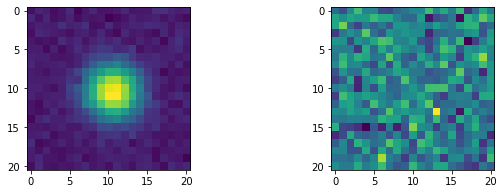

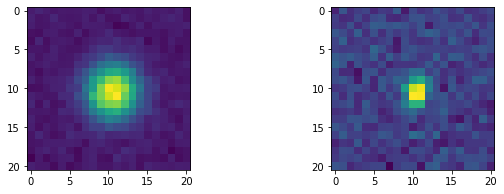

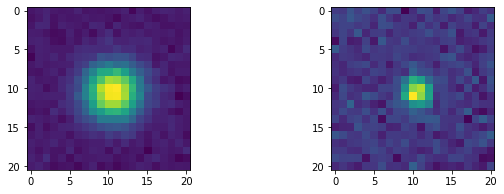

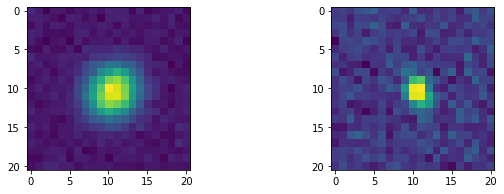

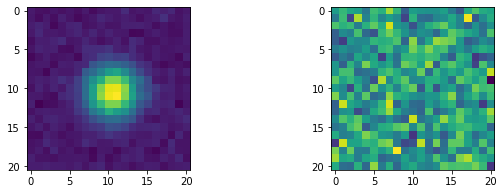

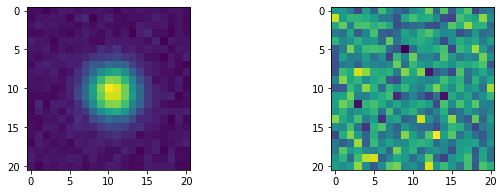

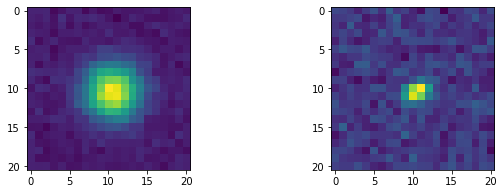

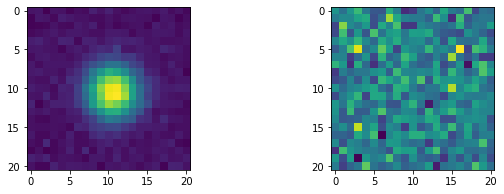

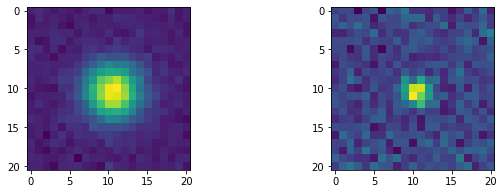

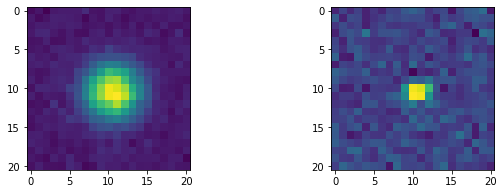

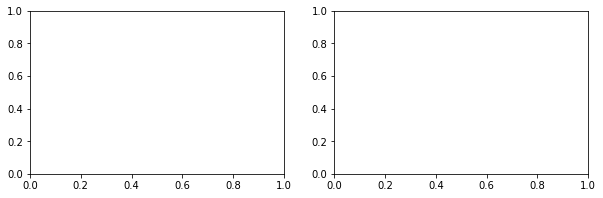

In [22]:
#SAMPLES OF SIMULATED DATA
#creates a loop that will execute 25 times. 
for i in range(25):
    f = plt.figure(figsize=(10,3)) #holds the created file
    ax = f.add_subplot(121) #correspond to number of rows, columns and index 
    ax2 = f.add_subplot(122)
    ax.imshow(data_sim[i,0,:,:])
    ax2.imshow(data_sim[i,1,:,:])

In [23]:
np.save('data_sim_scaled_images.npy', dataset2)
np.save('data_sim_scaled_labels.npy', labels)

In [24]:
data = np.load('datasets/data_sim_scaled_images.npy') #located dataset directior 

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/data_sim_scaled_images.npy'

In [6]:
labels = np.load('datasets/data_sim_scaled_labels.npy') #loaded the data and labels

In [10]:
labels[40]

0

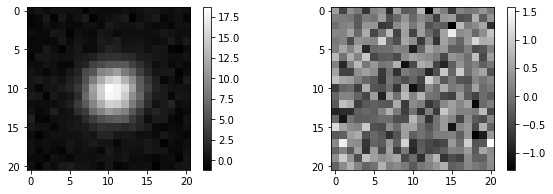

In [15]:
f = plt.figure(figsize=(10,3)) #creates a new figure with size 10x3 inches
ax = f.add_subplot(121) 
ax2 = f.add_subplot(122)    
fig_1 = ax.imshow(data[500,:,:,0], cmap='gray')
fig_2 = ax2.imshow(data[500,:,:,1], cmap='gray')

f.colorbar(fig_1, ax=ax)
f.colorbar(fig_2, ax=ax2)

plt.savefig('pictures/datasim_tr3.png')


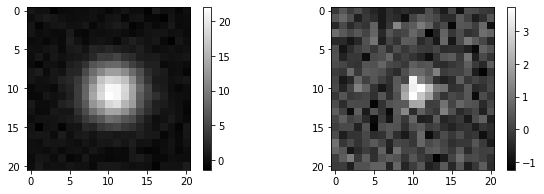

In [18]:
f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)    
fig_1 = ax.imshow(data[5,:,:,0], cmap='gray')
fig_2 = ax2.imshow(data[5,:,:,1], cmap='gray')

f.colorbar(fig_1, ax=ax)
f.colorbar(fig_2, ax=ax2)

plt.savefig('pictures/datasim_nontr3.png')

In [14]:
data_real = np.load('datasets/galaxy_ic4559_images_scaled.npy')

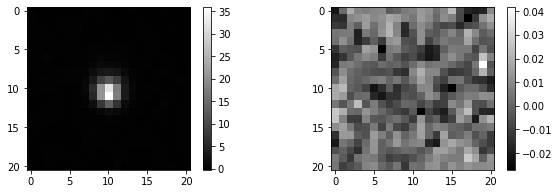

In [36]:
f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)    
fig_1 = ax.imshow(data_real[400,:,:,0], cmap='gray')
fig_2 = ax2.imshow(data_real[400,:,:,1], cmap='gray')

f.colorbar(fig_1, ax=ax)
f.colorbar(fig_2, ax=ax2)
plt.savefig('pictures/datareal_tr.png')

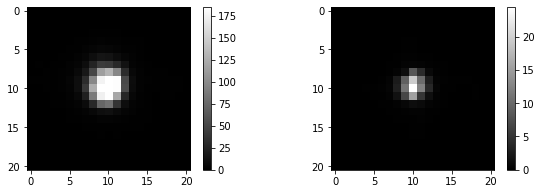

In [37]:
f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)    
fig_1 = ax.imshow(data_real[100,:,:,0], cmap='gray')
fig_2 = ax2.imshow(data_real[100,:,:,1], cmap='gray')

f.colorbar(fig_1, ax=ax)
f.colorbar(fig_2, ax=ax2)

plt.savefig('pictures/datareal_nontr.png')